In [4]:
import modin.pandas as pd

from cryptsmash.utils import inv_chi_squared, frequency_table, index_of_coincidence, ngram_count
from cryptsmash.plaintext import English

In [5]:
# https://www.kaggle.com/datasets/mikeortman/wikipedia-sentences
with open("wikisent2.txt", 'r') as f:
    sentences = f.read().split("\n")

df = pd.DataFrame(sentences, columns=['plaintext'])
alphabet = set(['\n'])

# https://www.kaggle.com/datasets/alvations/old-newspapers
# cat old-newspaper.tsv| awk -F "\t" '{if($1=="English"){print $4}}' | tee english-newspaper.txt
with open("english-newspaper.txt", 'r', newline='') as f:
    data = f.read().split("\n")

data = data

for sentence in data:
    for char in sentence:
        alphabet.add(char)

df = pd.concat([pd.DataFrame({'plaintext': data}),  ], ignore_index=True)

# df = df.sample(frac=.001, random_state=1337)

# Clean up some stuffs
del sentences
del sentence
del data


To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2024-02-08 10:33:57,156	INFO worker.py:1724 -- Started a local Ray instance.
(raylet) [2024-02-08 10:40:57,122 E 71543 71543] (raylet) node_manager.cc:3022: 5 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 3f7f9031ad937ef6cbbbcffa701ee74b8b9b82e9642093aa36866201, IP: 10.0.10.157) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 10.0.10.157`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker 

In [6]:
df['plain_len'] = df.apply(lambda r: len(r['plaintext']), axis=1)
# At least 5 letter cipher (which is pretty short anyways)
df = df[df['plain_len'] > 4]
df.info()


<class 'modin.pandas.dataframe.DataFrame'>
Index: 1009808 entries, 0 to 1010241
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   plaintext  1009808 non-null  object
 1   plain_len  1009808 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 23.1+ MB


In [7]:
df['plain_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['plaintext']), English.byte_distrib, r['plain_len']), axis=1)
# df['plain_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['plaintext'], 2), English.bigrams, r['plain_len']-2), axis=1)
df['plain_ioc'] = df.apply(lambda r: index_of_coincidence(r['plaintext']), axis=1)
# df.head()

In [8]:
df.describe().apply(lambda s: s.apply(lambda x:format(x,'f')))

,plain_len,plain_chisq,plain_ioc
count,1009808.000000,1009808.000000,1009808.000000
mean,202.352052,0.002670,0.062382
std,133.547487,0.003913,0.011326
min,5.000000,0.000024,0.000000
25%,111.000000,0.000999,0.059226
50%,186.000000,0.001444,0.063966
75%,269.000000,0.002418,0.067953
max,11384.000000,0.051053,1.000000


In [9]:
df.head()

,plaintext,plain_len,plain_chisq,plain_ioc
0,"He wasn't home alone, apparently.",33,0.008086,0.047348
1,The St. Louis plant had to close. It would die...,153,0.001755,0.066993
2,WSU's plans quickly became a hot topic on loca...,177,0.001517,0.063238
3,The Alaimo Group of Mount Holly was up for a c...,498,0.000540,0.066455
4,And when it's often difficult to predict a law...,246,0.001092,0.067994


In [10]:
import random
random.seed(1337)

# Transposition Ciphers
from cryptsmash import railfence

df['railfence'] = df.apply(lambda r: railfence.encrypt(r['plaintext'], random.randint(2, r['plain_len']-1)), axis=1)

# Should look the same since these stats don't take into account order
df['railfence_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['railfence']), English.byte_distrib, len(r['railfence'])), axis=1)
# df['railfence_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['railfence'], 2), English.bigrams, len(r['railfence'])-2), axis=1)
df['railfence_ioc'] = df.apply(lambda r: index_of_coincidence(r['railfence']), axis=1)

df.drop(['railfence'], axis=1, inplace=True)

In [11]:
import string

# Monoalphabetic Substitutions
from cryptsmash import affine
import numpy as np

def rnd_key(size):
    a = random.randint(1, size-1)
    while np.gcd(a, size) != 1:
        a = random.randint(1, size-1)
    
    return a, random.randint(0, size-1)

df['affine'] = df.apply(lambda r: affine.encrypt(r['plaintext'], rnd_key(len(r['plaintext'])), alphabet=string.printable), axis=1)
df['affine_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['affine']), English.byte_distrib, len(r['affine'])), axis=1)
# df['affine_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['affine'], 2), English.bigrams, len(r['affine'])-2), axis=1)
df['affine_ioc'] = df.apply(lambda r: index_of_coincidence(r['affine']), axis=1)
df.drop(['affine'], axis=1, inplace=True)

In [12]:
from cryptsmash import substitution

def rnd_key(alphabet):
    d = dict()
    for k,v in zip(alphabet, random.sample(alphabet, k=len(alphabet))):
        d[k] = v
    return d

df['sub'] = df.apply(lambda r:substitution.encrypt(r['plaintext'], rnd_key(string.printable)), axis=1)
df['sub_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['sub']), English.byte_distrib, len(r['sub'])), axis=1)
# df['sub_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['sub'], 2), English.bigrams, len(r['sub'])-2), axis=1)
df['sub_ioc'] = df.apply(lambda r:index_of_coincidence(r['sub']), axis=1)
df.drop(['sub'], axis=1, inplace=True)

In [13]:
# Polyalphabetic Substitions
from cryptsmash import vigenere
from faker import Faker
Faker.seed(1337)
faker = Faker()

df['vigenere'] = df.apply(lambda r: vigenere.encrypt(r['plaintext'], faker.word(), alphabet), axis=1)
df['vigenere_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['vigenere']), English.byte_distrib, len(r['vigenere']), [bytes(a,'utf8') for a  in alphabet]), axis=1)
# df['vigenere_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['vigenere'], 2), English.bigrams, len(r['vigenere'])-2), axis=1)
df['vigenere_ioc'] = df.apply(lambda r:index_of_coincidence(r['vigenere']), axis=1)
df.drop(['vigenere'], axis=1, inplace=True)
df.describe().apply(lambda s: s.apply(lambda x:format(x,'f')))

,plain_len,plain_chisq,plain_ioc,railfence_chisq,railfence_ioc,affine_chisq,affine_ioc,sub_chisq,sub_ioc,vigenere_chisq,vigenere_ioc
count,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000,1009808.000000
mean,202.352052,0.002670,0.062382,0.002670,0.062382,0.002670,0.083716,0.002670,0.062382,0.001098,0.018153
std,133.547487,0.003913,0.011326,0.003913,0.011326,0.003913,0.074556,0.003913,0.011326,0.001624,0.006691
min,5.000000,0.000024,0.000000,0.000024,0.000000,0.000024,0.000000,0.000024,0.000000,0.000010,0.000000
25%,111.000000,0.000999,0.059226,0.000999,0.059226,0.000999,0.061409,0.000999,0.059226,0.000409,0.014281
50%,186.000000,0.001444,0.063966,0.001444,0.063966,0.001444,0.066667,0.001444,0.063966,0.000591,0.017381
75%,269.000000,0.002418,0.067953,0.002418,0.067953,0.002418,0.073120,0.002418,0.067953,0.000990,0.021198
max,11384.000000,0.051053,1.000000,0.051053,1.000000,0.051053,1.000000,0.051053,1.000000,0.021535,0.329670


In [14]:
# XOR is techinicaly a polyalphabetic sub?
from cryptsmash import xor

df['xor'] = df.apply(lambda r: xor.encrypt(bytes(r['plaintext'], 'utf8'), bytes(faker.word(), 'utf8')), axis=1)
df['xor_chisq'] = df.apply(lambda r: inv_chi_squared(frequency_table(r['xor']), English.byte_distrib, len(r['xor']), [bytes(a,'utf8') for a  in alphabet]), axis=1)
# df['xor_bigram_chisq'] = df.apply(lambda r: inv_chi_squared(ngram_count(r['xor'], 2), English.bigrams, len(r['xor'])-2), axis=1)
df['xor_ioc'] = df.apply(lambda r:index_of_coincidence(r['xor']), axis=1)
df.drop(['xor'], axis=1, inplace=True)

Order of rows could be different from pandas.


<Axes: xlabel='value', ylabel='Density'>

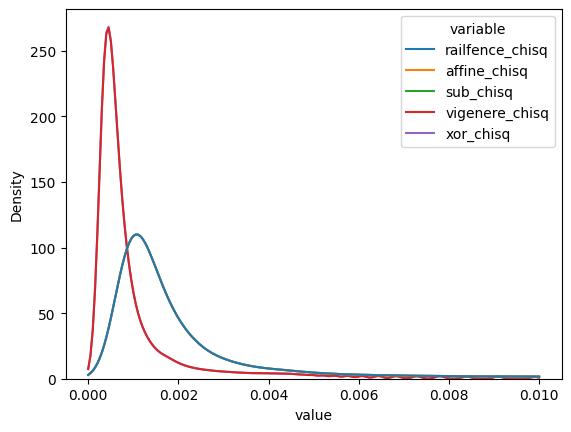

In [15]:
import seaborn as sns

inv_chi_df = df[['railfence_chisq', 'affine_chisq', 'sub_chisq', 'vigenere_chisq', 'xor_chisq']].melt()
sns.kdeplot(inv_chi_df, x='value', hue='variable', clip=(0, .01))

In [16]:
# bigram_chisq_df = df[['railfence_bigram_chisq', 'affine_bigram_chisq', 'sub_bigram_chisq', 'vigenere_bigram_chisq', 'xor_bigram_chisq']].melt()
# sns.kdeplot(inv_chi_df, x='value', hue='variable', clip=(0,.02))

<Axes: xlabel='value', ylabel='Density'>

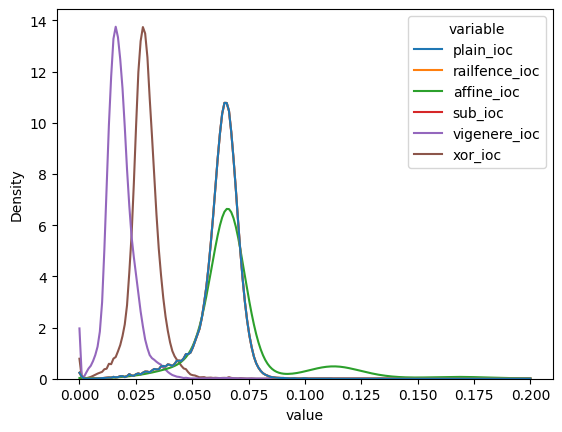

In [17]:
ioc_df = df[['plain_ioc', 'railfence_ioc', 'affine_ioc', 'sub_ioc', 'vigenere_ioc', 'xor_ioc']].melt()
sns.kdeplot(ioc_df, x='value', hue='variable', clip=(0, .2))

# plain == railfence == sub

In [18]:
df.head()

,plaintext,plain_len,plain_chisq,plain_ioc,railfence_chisq,railfence_ioc,affine_chisq,affine_ioc,sub_chisq,sub_ioc,vigenere_chisq,vigenere_ioc,xor_chisq,xor_ioc
0,"He wasn't home alone, apparently.",33,0.008086,0.047348,0.008086,0.047348,0.008086,0.056818,0.008086,0.047348,0.003324,0.015152,0.003324,0.045455
1,The St. Louis plant had to close. It would die...,153,0.001755,0.066993,0.001755,0.066993,0.001755,0.066993,0.001755,0.066993,0.000719,0.018662,0.000719,0.028724
2,WSU's plans quickly became a hot topic on loca...,177,0.001517,0.063238,0.001517,0.063238,0.001517,0.065614,0.001517,0.063238,0.000621,0.027221,0.000621,0.040190
3,The Alaimo Group of Mount Holly was up for a c...,498,0.000540,0.066455,0.000540,0.066455,0.000540,0.066455,0.000540,0.066455,0.000221,0.011967,0.000221,0.027013
4,And when it's often difficult to predict a law...,246,0.001092,0.067994,0.001092,0.067994,0.001092,0.067994,0.001092,0.067994,0.000447,0.013141,0.000447,0.031724


In [19]:
plain_df = df[['plain_chisq', 'plain_ioc']]
plain_df.rename(columns={"plain_chisq": "inv_chi_sq", "plain_ioc": "ioc"}, inplace=True)
plain_df['type'] = plain_df.apply(lambda r: "plaintext", axis=1)

rail_df = df[['railfence_chisq', 'railfence_ioc']]
rail_df.rename(columns={"railfence_chisq": "inv_chi_sq", "railfence_ioc": "ioc"}, inplace=True)
rail_df['type'] = rail_df.apply(lambda r: "railfence", axis=1)

affine_df = df[['affine_chisq', 'affine_ioc']]
affine_df.rename(columns={"affine_chisq": "inv_chi_sq", "affine_ioc": "ioc"}, inplace=True)
affine_df['type'] = affine_df.apply(lambda r: "affine", axis=1)

sub_df = df[['sub_chisq', 'sub_ioc']]
sub_df.rename(columns={"sub_chisq": "inv_chi_sq", "sub_ioc": "ioc"}, inplace=True)
sub_df['type'] = sub_df.apply(lambda r: "substitution", axis=1)

vigenere_df = df[['vigenere_chisq', 'vigenere_ioc']]
vigenere_df.rename(columns={"vigenere_chisq": "inv_chi_sq", "vigenere_ioc": "ioc"}, inplace=True)
vigenere_df['type'] = vigenere_df.apply(lambda r: "vigenere", axis=1)

xor_df = df[['xor_chisq', 'xor_ioc']]
xor_df.rename(columns={"xor_chisq": "inv_chi_sq", "xor_ioc": "ioc"}, inplace=True)
xor_df['type'] = xor_df.apply(lambda r: "xor", axis=1)

detect_df = pd.concat([plain_df, rail_df, affine_df, sub_df, vigenere_df, xor_df])

del plain_df
del rail_df
del affine_df
del sub_df
del vigenere_df
del xor_df

detect_df.describe()

,inv_chi_sq,ioc
count,6.058848e+06,6.058848e+06
mean,2.144845e-03,5.300348e-02
std,3.410297e-03,3.880651e-02
min,9.666516e-06,0.000000e+00
25%,6.946072e-04,2.878007e-02
50%,1.163147e-03,5.974125e-02
75%,2.018473e-03,6.657917e-02
max,5.105330e-02,1.000000e+00


<Axes: xlabel='inv_chi_sq', ylabel='ioc'>

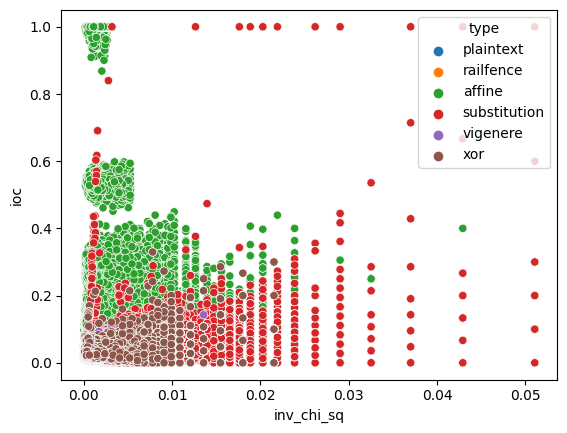

In [17]:
sns.scatterplot(detect_df, x='inv_chi_sq', y='ioc', hue='type')


In [22]:
detect_df = detect_df[detect_df['type'] != 'plaintext']
detect_df.head()

,inv_chi_sq,ioc,type
0,0.008086,0.047348,railfence
1,0.001755,0.066993,railfence
2,0.001517,0.063238,railfence
3,0.000540,0.066455,railfence
4,0.001092,0.067994,railfence


In [19]:
import numpy as np

# plain == railfence == sub
labels = {
    'railfence': 0,
    'affine': 1,
    'substitution':2,
    'vigenere': 3,
    'xor': 4
}

# detect_df['label'] = detect_df.apply(lambda r: labels[r['type']], axis=1)
# detect_df.drop(['type'], axis=1, inplace=True)

X = detect_df[['inv_chi_sq', 'ioc']].to_numpy()
Y = np.array([labels[t] for t in detect_df['type']])

In [20]:
results_df = pd.DataFrame(columns=["model_type", "training_score", "cross_valid_ave"])

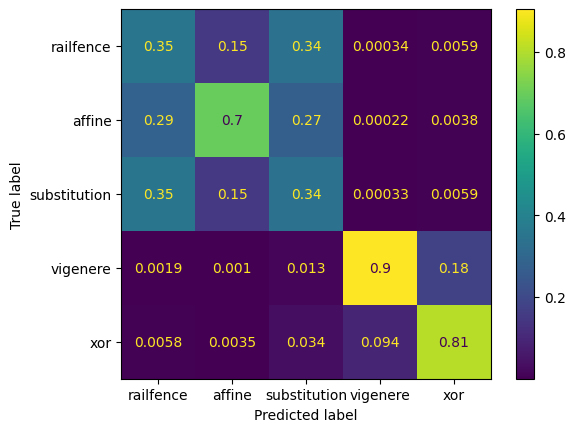

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import Parallel, delayed
from sklearn.model_selection import cross_val_score

n_cores = 16

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8, random_state=1337)

svc = make_pipeline(StandardScaler(), SVC())

svc.fit(X_train, Y_train)

samples = X_test.shape[0]
parallel = Parallel(n_jobs=n_cores)
Y_hat = parallel(delayed(svc.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
labels_ids = [k for k in labels.keys()]
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)



In [27]:
import skops.io as sio

sio.dump(svc, "svc_detect.skops")

score = svc.score(X_train, Y_train)
print(f"score: {score}")
cross = cross_val_score(svc, X_train, Y_train, n_jobs=n_cores).mean()

results_df = pd.concat([pd.DataFrame([["svc", score, cross]], columns=results_df.columns), results_df], ignore_index=True)


score: 0.5751925118438357


score: 0.7156776337680034


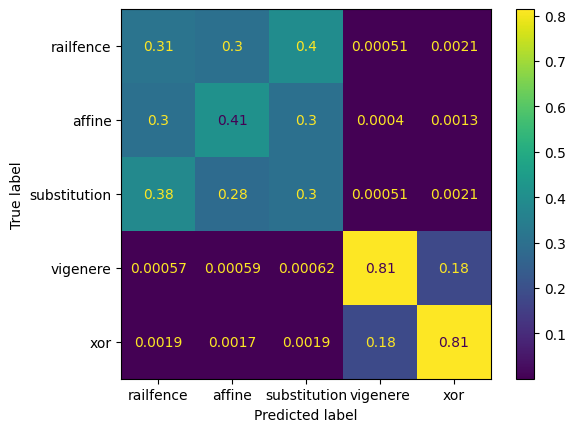

In [23]:
# TODO
# try other classifiers

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# make_pipeline(StandardScaler(), SVC())

tree = make_pipeline(StandardScaler(), DecisionTreeClassifier())
tree.fit(X_train, Y_train)
Y_hat = parallel(delayed(tree.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
score = tree.score(X_train, Y_train)
print(f"score: {score}")
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)
cross = cross_val_score(tree, X_train, Y_train, n_jobs=n_cores).mean()
results_df = pd.concat([pd.DataFrame([["tree", score, cross]], columns=results_df.columns), results_df], ignore_index=True)
sio.dump(tree, "tree_detect.skops")



score: 0.6777030881117995


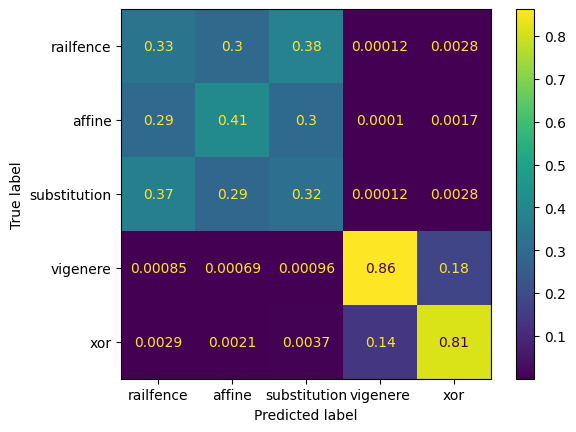

In [24]:
kneighbor = make_pipeline(StandardScaler(), KNeighborsClassifier())
kneighbor.fit(X_train, Y_train)
Y_hat = parallel(delayed(kneighbor.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
score = kneighbor.score(X_train, Y_train)
print(f"score: {score}")
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)
cross = cross_val_score(kneighbor, X_train, Y_train, n_jobs=n_cores).mean()
results_df = pd.concat([pd.DataFrame([["kneighbor", score, cross]], columns=results_df.columns), results_df], ignore_index=True)
sio.dump(kneighbor, "kneighbor_detect.skops")

score: 0.6707354269326447


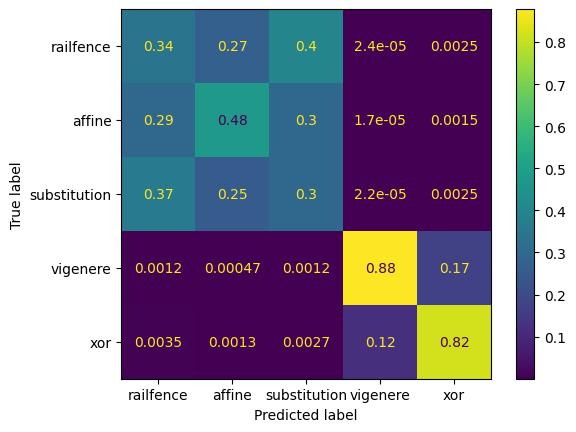

In [25]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(estimators=[('svc', svc), ('tree', tree), ('kneighbor', kneighbor)], voting='hard')
vote.fit(X_train, Y_train)
Y_hat = parallel(delayed(vote.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
score = vote.score(X_train, Y_train)
print(f"score: {score}")
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)
cross = cross_val_score(vote, X_train, Y_train, n_jobs=n_cores).mean()
results_df = pd.concat([pd.DataFrame([["vote", score, cross]], columns=results_df.columns), results_df], ignore_index=True)
sio.dump(vote, "vote_detect.skops")

In [28]:
results_df

,model_type,training_score,cross_valid_ave
0,svc,0.575193,0.574816
1,vote,0.670735,0.556936
2,kneighbor,0.677703,0.548440
3,tree,0.715678,0.530516


Seems to be able to distinguish between Transposition/Monoalphabetic Substitution and Vigenere/XOR, but doesnt really do a great job within each group

so what if we just turned this into a binary classifiction of Transposition/Monoalphabetic Substitution VS Vigenere/XOR?
then just handle each subgroup from there using heursitics?

SVC seems to do the best, so going to use that

In [32]:
labels = {
    'railfence': 0,
    'affine': 0,
    'substitution':0,
    'vigenere': 1,
    'xor': 1
}

# detect_df['label'] = detect_df.apply(lambda r: labels[r['type']], axis=1)
# detect_df.drop(['type'], axis=1, inplace=True)

X = detect_df[['inv_chi_sq', 'ioc']].to_numpy()
Y = np.array([labels[t] for t in detect_df['type']])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8, random_state=1337)

bin_svc = make_pipeline(StandardScaler(), SVC())

bin_svc.fit(X_train, Y_train)

samples = X_test.shape[0]


238636.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
238637.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
238637.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
238637.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
238637.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
238637.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
238638.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
238638.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
238638.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
238638.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
238638.71s - pydevd: Sending m

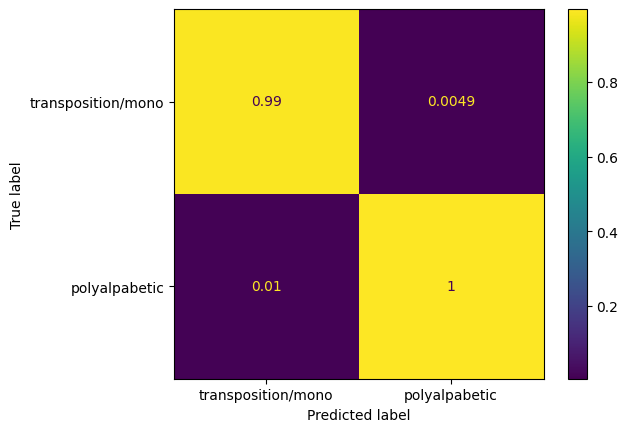

In [38]:
Y_hat = parallel(delayed(bin_svc.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
labels_ids = ["transposition/mono", "polyalpabetic"]
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)

In [36]:
sio.dump(bin_svc, "bin_svc_detect.skops")

score = bin_svc.score(X_train, Y_train)
print(f"score: {score}")
cross = cross_val_score(bin_svc, X_train, Y_train, n_jobs=n_cores).mean()
print(f"cross: {cross}")

score: 0.9919836246098268


209933.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
209933.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
209933.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
209934.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
209934.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
209934.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
209934.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
209934.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
209935.02s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
209935.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
209935.38s - pydevd: Sending m

cross: 0.9921985168976969


In [43]:
labels = {
    'vigenere': 0,
    'xor': 1
}

polyalphabetic = detect_df[(detect_df['type'] == 'vigenere') | (detect_df['type'] == 'xor')]
polyalphabetic.describe()

,inv_chi_sq,ioc
count,2.019616e+06,2.019616e+06
mean,1.095423e-03,2.356370e-02
std,1.619155e-03,8.766238e-03
min,9.666516e-06,0.000000e+00
25%,4.089208e-04,1.691542e-02
50%,5.912883e-04,2.376708e-02
75%,9.904117e-04,2.939318e-02
max,2.153497e-02,3.296703e-01


273442.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
273442.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
273442.86s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
273443.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
273443.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
273443.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
273443.59s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
273443.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
273443.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
273444.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
273444.30s - pydevd: Sending m

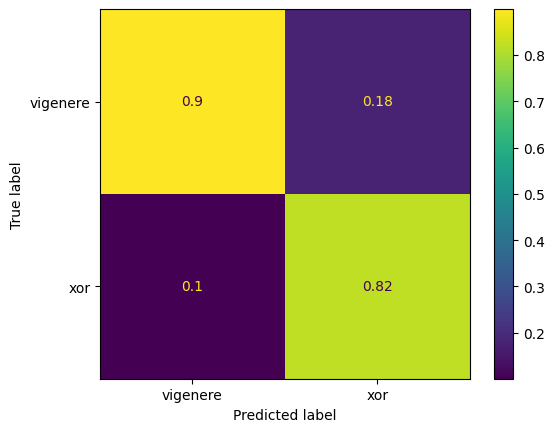

In [45]:

X = polyalphabetic[['inv_chi_sq', 'ioc']].to_numpy()
Y = np.array([labels[t] for t in polyalphabetic['type']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8, random_state=1337)
poly_svc = make_pipeline(StandardScaler(), SVC())
poly_svc.fit(X_train, Y_train)
samples = X_test.shape[0]
Y_hat = parallel(delayed(poly_svc.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
labels_ids = ["vigenere", "xor"]
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)


In [46]:
sio.dump(poly_svc, "poly_svc_detect.skops")

score = poly_svc.score(X_train, Y_train)
print(f"score: {score}")
cross = cross_val_score(poly_svc, X_train, Y_train, n_jobs=n_cores).mean()
print(f"cross: {cross}")

score: 0.8568811382367432


275363.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
275363.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
275363.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
275363.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
275364.14s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
275364.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
275364.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
275364.69s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
275364.87s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
275365.06s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
275365.23s - pydevd: Sending m

cross: 0.8567697303566841


In [24]:
labels = {
    'railfence': 0,
    'affine': 1,
    'substitution':2,
}

trans_mono = detect_df[(detect_df['type'] != 'vigenere') & (detect_df['type'] != 'xor')]

X = trans_mono[['inv_chi_sq', 'ioc']].to_numpy()
Y = np.array([labels[t] for t in trans_mono['type']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8, random_state=1337)
trans_mono_svc = make_pipeline(StandardScaler(), SVC())
trans_mono_svc.fit(X_train, Y_train)
samples = X_test.shape[0]


NameError: name 'parallel' is not defined

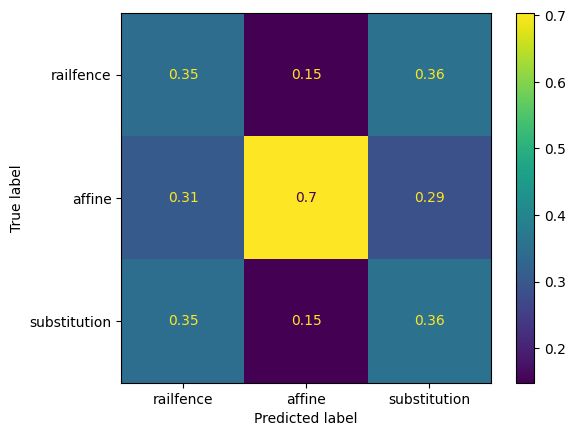

In [26]:
samples = X_test.shape[0]
n_cores = 16

parallel = Parallel(n_jobs=n_cores)
Y_hat = parallel(delayed(trans_mono_svc.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
labels_ids = ["railfence", "affine", "substitution"]
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)

In [27]:
sio.dump(trans_mono_svc, "trans_mono_svc_detect.skops")

score = trans_mono_svc.score(X_train, Y_train)
print(f"score: {score}")
cross = cross_val_score(trans_mono_svc, X_train, Y_train, n_jobs=n_cores).mean()
print(f"cross: {cross}")

score: 0.3945045586283843
cross: 0.39312806023072416


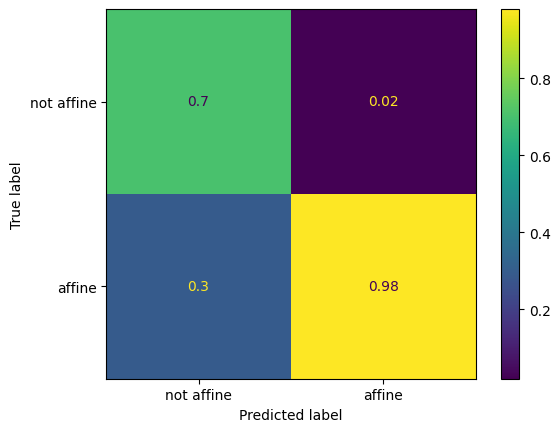

In [28]:
labels = {
    'railfence': 0,
    'affine': 1,
    'substitution':0,
}

affine_df = detect_df[(detect_df['type'] != 'vigenere') & (detect_df['type'] != 'xor')]

X = affine_df[['inv_chi_sq', 'ioc']].to_numpy()
Y = np.array([labels[t] for t in affine_df['type']])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.8, random_state=1337)
affine_svc = make_pipeline(StandardScaler(), SVC())
affine_svc.fit(X_train, Y_train)
samples = X_test.shape[0]

Y_hat = parallel(delayed(affine_svc.predict)(X_test[(samples//n_cores) * i:(samples//n_cores) * (i+1)]) for i in range(n_cores))
Y_hat = np.vstack(Y_hat)
Y_hat = np.resize(Y_hat, Y_test.shape)
labels_ids = ["not affine", "affine"]
ConfusionMatrixDisplay.from_predictions(Y_test, Y_hat, normalize='pred', display_labels=labels_ids)

In [29]:
sio.dump(affine_svc, "affine_svc_detect.skops")

score = affine_svc.score(X_train, Y_train)
print(f"score: {score}")
cross = cross_val_score(affine_svc, X_train, Y_train, n_jobs=n_cores).mean()
print(f"cross: {cross}")

score: 0.7173320305537033
cross: 0.7172544584117866
